In [13]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2

In [16]:
data = sio.loadmat('./relative_attributes_v2/relative_attributes/pubfig/data.mat')
# data = sio.loadmat('./relative_attributes_v2/relative_attributes/osr/data.mat')
attr_names = []
for x in data['attribute_names'][0]:
    attr_names.append(x[0])
data['attribute_names'] = attr_names
data['feat']=np.array(data['feat'])
data['im_names'] = data['im_names'][0]
data['class_labels'] = data['class_labels'][:, 0]
data['used_for_training'] = data['used_for_training'][:, 0]
data['class_names'] = data['class_names'][0]

In [26]:
# sum(np.logical_and(data['class_labels']==1 , data['used_for_training']==1))
# sum(data['class_labels']==1)
# Now construct a RBF SVM classifier with data['used for training'] 


95

In [4]:
from sklearn.svm import SVC

In [17]:
binclassifier=[]
X=[]
Y=[]

for Class in range(len(data['class_names'])):
    binclassifier.append(SVC(gamma='auto',kernel='rbf',probability=True))
    X.append([])
    Y.append([])
    for i in range(len(data['feat'])):
        if(data['class_labels'][i]==Class+1  and data['used_for_training'][i]==1):
            X[Class].append(data['feat'][i])
            Y[Class].append(1)
    #     elif(data['used_for_training'][i]==1):
        elif(data['class_labels'][i]!=Class+1 and data['used_for_training'][i]==1):
            X[Class].append(data['feat'][i])
            Y[Class].append(-1)
    binclassifier[Class].fit(X[Class],Y[Class])

In [71]:
data['attribute_names']

['Male',
 'White',
 'Young',
 'Smiling',
 'Chubby',
 'VisibleForehead',
 'BushyEyebrows',
 'NarrowEyes',
 'PointyNose',
 'BigLips',
 'RoundFace']

In [865]:
data['class_names']

array([array(['tallbuilding'], dtype='<U12'),
       array(['insidecity'], dtype='<U10'),
       array(['street'], dtype='<U6'), array(['highway'], dtype='<U7'),
       array(['coast'], dtype='<U5'),
       array(['opencountry'], dtype='<U11'),
       array(['mountain'], dtype='<U8'), array(['forest'], dtype='<U6')],
      dtype=object)

[0.12707239 0.12705965 0.12712153 0.11423831 0.12607479 0.12606054
 0.1261364  0.12623637] [4]
[0.12712412 0.12703123 0.12709859 0.10294822 0.12883142 0.12881604
 0.12898626 0.12916412] [4]
[0.12958029 0.12959194 0.12986854 0.08870877 0.13053727 0.13050012
 0.13054616 0.13066691] [4]
[0.1347974  0.13170364 0.12882027 0.11340708 0.12694459 0.12397243
 0.12129881 0.11905577] [4]
[0.12809905 0.12796189 0.12786223 0.10190837 0.1284464  0.12848497
 0.12859457 0.12864252] [4]
[0.13096663 0.13099924 0.13139552 0.06875532 0.13444481 0.13438021
 0.13444288 0.13461539] [4]
[0.08422629 0.09340612 0.10543412 0.08609047 0.11990302 0.13932102
 0.16641482 0.20520414] [4]
[0.14600717 0.14014493 0.13514519 0.08185255 0.13104946 0.1261122
 0.1217802  0.1179083 ] [4]


accuracy is : 75.51813471502591


In [52]:
import random
data['used_for_feedback']=[]
for i in range(len(data['feat'])):
    if(data['used_for_training'][i]!=1 and random.uniform(0, 1)<0.3):
        data['used_for_feedback'].append(1)
    else:
        data['used_for_feedback'].append(0)

accuracy is : 74.48186528497409
accuracy is : 75.77720207253886
accuracy is : 77.20207253886011
accuracy is : 76.6839378238342
accuracy is : 76.16580310880829
accuracy is : 75.0
accuracy is : 75.38860103626943
accuracy is : 74.35233160621762
accuracy is : 74.48186528497409
accuracy is : 73.44559585492227
accuracy is : 75.90673575129534
accuracy is : 76.03626943005182
accuracy is : 75.64766839378238
accuracy is : 75.77720207253886
accuracy is : 75.77720207253886
accuracy is : 74.22279792746114


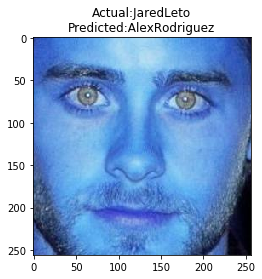

In [70]:
# # Now query the image with maximum entropy min(classifier.predict_proba(data['feat'][i])[0])
# xStar=int(np.argmax(classifier.predict_proba(data['feat']))/8)
# plt.imshow(cv2.imread('./relative_attributes_v2/relative_attributes/osr/spatial_envelope_256x256_static_8outdoorcategories/'+data['im_names'][xStar][0]))
# data['class_names'][data['class_labels'][xStar]-1][0],data['class_names'][classifier.predict(data['feat'][xStar].reshape(1,-1))[0]-1][0], data['attribute_names'], data['class_names']
while(data['class_labels'][maxIndex]-1==predictedClass[maxIndex]):
    count=0
    count1=0
    predictedClass=[]
    for i in range(len(data['feat'])):
    #     if(data['used_for_training'][i]==1):
    #         continue
        count1+=1
        predictedClass.append(-1)
        maxProb=0
        den=0
    #     for j in range(len(data['class_names'])):
    #         den+=binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]
        for j in range(len(data['class_names'])):
            if(maxProb<binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]):
                maxProb=binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]
                predictedClass[len(predictedClass)-1]=j
    #         print(binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1])
    #     print(predictedClass,data['class_labels'][i]-1)
        if(predictedClass[len(predictedClass)-1]==data['class_labels'][i]-1):
            count+=1
    # print()
    #     print(classifier.predict_proba([data['feat'][i]]),data['class_labels'][i])
    # print(trainingCount,count1,count/len(data['feat']))
    print("accuracy is :",100*count/count1)
    maxEntropy=0
    maxIndex=-1
    for i in range(len(data['feat'])):
        if(data['used_for_feedback'][i]==1):
            den=0
            for j in range(len(data['class_names'])):
                den+=binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]
            for j in range(len(data['class_names'])):
                prob=binclassifier[j].predict_proba(data['feat'][i].reshape(1,-1))[0][1]
                if(maxEntropy<prob/den):
                    maxEntropy=prob/den
                    maxIndex=i
    maxIndex
    plt.imshow(cv2.imread('./relative_attributes_v2/relative_attributes/pubfig/images/'+data['im_names'][maxIndex][0]))
    plt.title("Actual:"+ data['class_names'][data['class_labels'][maxIndex]-1][0]+ "\n"+ "Predicted:"+ data['class_names'][predictedClass[maxIndex]][0])
    # data['class_labels'][maxIndex]-1][0] predictedClass[maxIndex]
    # print(predictedClass[maxIndex])
    # print(len(predictedClass))
    data['used_for_feedback'][maxIndex]=0
    for j in range(len(data['class_names'])):
        if(j==data['class_labels'][maxIndex]-1):
            X[j].append(data['feat'][maxIndex])
            Y[j].append(1)
        else:
            X[j].append(data['feat'][maxIndex])
            Y[j].append(-1)
        binclassifier[j]=SVC(gamma='auto',kernel='rbf',probability=True)
        binclassifier[j].fit(X[j],Y[j])

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


['Male',
 'White',
 'Young',
 'Smiling',
 'Chubby',
 'VisibleForehead',
 'BushyEyebrows',
 'NarrowEyes',
 'PointyNose',
 'BigLips',
 'RoundFace']

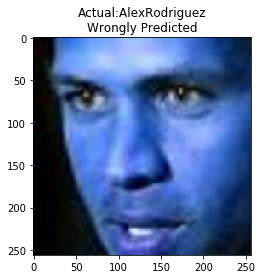

In [477]:
# data['class_names']
import matplotlib.pyplot as plt
import cv2
plt.imshow(cv2.imread('./relative_attributes_v2/relative_attributes/pubfig/images/'+data['im_names'][maxi][0]))
if(classifier.predict(data['feat'][maxi])!=1):
    plt.title("Actual:"+ data['im_names'][maxi][0].split('_')[0]+ "\n"+ "Wrongly Predicted")
data['attribute_names']

In [453]:
countfeedback=0
counttraining=0
countrem=0
for i in range(len(data['feat'])):
    if(data['used_for_feedback'][i]==1):
        countfeedback+=1
    elif(data['used_for_training'][i]==1):
        counttraining+=1
    else:
        countrem+=1
countfeedback,counttraining,countrem

(184, 241, 347)

In [270]:
count=[0,0,0,0,0,0,0,0]
for i in range(len(data['feat'])):
    if(data['used_for_training'][i]==1):
        count[data['class_labels'][i]-1]+=1
count

[30, 30, 30, 31, 30, 30, 30, 30]

In [687]:
a=[1,2]
c=[2,3]
b= [a,c]
np.argmax(b)

3